# Download dataset

In [1]:
!pip install -qU torch_snippets
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks -p ./Dataset
!unzip ./Dataset/open-images-bus-trucks.zip -d ./Dataset

Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
open-images-bus-trucks.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./Dataset/open-images-bus-trucks.zip
replace ./Dataset/df.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Import required libraries

In [2]:
import os
from torch_snippets import *
from torch_snippets.torch_loader import Report
from PIL import Image
import torchvision
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchinfo import summary
import torch 
import glob
from sklearn.model_selection import train_test_split
# specify the device
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')
if torch.cuda.is_available():
    print(f'number of available GPU(s): {torch.cuda.device_count()}')
    print(f'current GPU(s): {torch.cuda.get_device_name()}')

device: cuda
number of available GPU(s): 1
current GPU(s): NVIDIA GeForce RTX 4060


# Read dataset

In [3]:
Img_root = './Dataset/images/images'
raw_df_data = pd.read_csv('./Dataset/df.csv')
raw_df_data.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


# Define the indices corresponding to labels and targets

In [4]:
label2target = {l:t+1 for t,l in enumerate(raw_df_data['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target) # 3 classes--> 0: background, 1: Bus, 2: Truck

# define preprocessing_image function to apply preprocessing on an image

In [5]:
def preprocess_image(img):
    """
    This function applies preprocessing on an image and returns a preprocessed image in torch format and on the corresponding device.

    Args:
        img (array): an input image

    Returns:
        Tensor: an image with preprocessing applied
    """
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

# Define dataset class

In [6]:
class OpenDataset(Dataset):
    def __init__(self,  df_data_inf = raw_df_data, image_dir ='./Dataset/images/images' ,width=224, hight=224):
        """
        this function intializes the reading necessary information to create a dataset for the training data
        Args:
            df_data_inf (_type_, optional): metadata of the images. Defaults to raw_df_data.
            image_dir (str, optional): directory of available images. Defaults to './Dataset/images/images'.
            width (int, optional): width of the image. Defaults to 224.
            hight (int, optional): hight of the image. Defaults to 224.
        """
        self.width = width
        self.hight = hight
        self.image_dir = image_dir
        self.images = glob.glob(self.image_dir+'/*')
        self.df_data_inf = df_data_inf
        self.image_infs = df_data_inf.ImageID.unique()
    
    # define the __getitem__ method, where we return the preprocessed image and the target value
    def __getitem__(self, idx):
        """
        Retrieves and preprocesses an image and its corresponding target data (bounding boxes and labels)  at the given index for the dataset.
    

        Args:
            idx (int): The index of the image and target data to retrieve from the dataset.

        Returns:
            tuple: A tuple containing:
                - img (torch.Tensor): The preprocessed image tensor with values normalized between 0 and 1.
                - target (dict): A dictionary containing:
                    - 'boxes' (torch.Tensor): A tensor of shape (N, 4) representing the ground truth bounding boxes 
                                            in absolute coordinates. Each box is in the format [xmin, ymin, xmax, ymax].
                    - 'labels' (torch.Tensor): A tensor of shape (N,) representing the class labels corresponding to 
                                            the bounding boxes.
        """
        
        # Extract image index
        image_id = self.image_infs[idx]
        # find the path 2 image
        path2image = find(image_id, self.images)
        # read the image
        img = Image.open(path2image).convert('RGB') # from BGR to RGB
        # resize the image and convert its values between 0 and 1
        img = np.array(img.resize((self.width, self.hight), resample = Image.BILINEAR))/255.
        img_meta_data = self.df_data_inf [self.df_data_inf ['ImageID'] == image_id]
        # extract labels in the image and save them as a list
        labels =   img_meta_data['LabelName'].values.tolist()    
        # extract ground truth bounding boxes coordinates on the image
        gt_bbs =   img_meta_data[['XMin', 'YMin', 'XMax', 'YMax']].values
        # convert the gt_bbs into absolute values
        gt_bbs[:, [0,2]] *= self.width
        gt_bbs[:, [1,3]] *= self.hight 
        # convert the coordinate format into uint and save them as a list
        boxes = gt_bbs.astype(np.uint32).tolist()
        # torch FRCNN expects the target to contain the absolute coordinates of bounding boxes and the label information 
        target = {}
        target ['boxes'] = torch.Tensor(boxes).float()
        target['labels'] = torch.Tensor([label2target[i] for i in labels]).long()      
        # apply preprocessing on the image
        img = preprocess_image(img)  
        return img, target
    # define collate_fn method and __len__ method
    def collate_fn(self, batch):
        """
        Custom collate function to be used in the DataLoader to handle batches of images and targets.

        Args:
            batch (list): A list of tuples, where each tuple contains:
                            - image (torch.Tensor): The image data as a tensor.
                            - target (dict): A dictionary containing:
                                - 'boxes' (torch.Tensor): Ground truth bounding boxes as (N, 4) tensors.
                                - 'labels' (torch.Tensor): Class labels for the bounding boxes.

        Returns:
            tuple: Two tuples:
               - First tuple: A batch of images as tensors.
               - Second tuple: A batch of target dictionaries, where each dictionary contains 'boxes' 
                               and 'labels' as tensors for the corresponding image.
        """
        return tuple(zip(*batch))
    
    def __len__(self):
        """
        Returns the total number of unique images in the dataset.
        This method is used by PyTorch's DataLoader to determine the size of the dataset  and the number of iterations per epoch.
    
        Returns:
        int: The number of unique image IDs in the dataset, corresponding to the total number of data samples available for training or inference.
        """
        return len(self.image_infs)

# Test the OpenDataset class

In [7]:
# Instantiate the OpenDataset class
test_dataset = OpenDataset(df_data_inf=raw_df_data, image_dir=Img_root, width=224, hight=224)
# Test the dataset by getting one sample (e.g., index 0)
test_img, test_target = test_dataset.__getitem__(10)
# Print the result to check
print(f'Image Tensor Shape: {test_img.shape}')
print(f'Target: {test_target}')

Image Tensor Shape: torch.Size([3, 224, 224])
Target: {'boxes': tensor([[  0.,   0., 223., 223.]]), 'labels': tensor([1])}


In [8]:
train_ids, val_ids = train_test_split(raw_df_data.ImageID.unique(),
                                      test_size= 0.1, random_state= 1402)
train_df , val_df = raw_df_data [raw_df_data['ImageID'].isin(train_ids)] ,  raw_df_data [raw_df_data['ImageID'].isin(val_ids)] 
# define train and validation datasets
train_dataset = OpenDataset(train_df)
val_dataset = OpenDataset(val_df)
# define the dataloaders
# Note: In PyTorch, the collate_fn is an argument used in the DataLoader class to define how to combine a list of data samples into a single batch. 
train_dataloader = DataLoader(train_dataset, batch_size = 8, collate_fn = train_dataset.collate_fn, drop_last= True)
test_dataloader = DataLoader(val_dataset, batch_size = 8, collate_fn = train_dataset.collate_fn, drop_last= True)

# Test Dataloaders

In [9]:
# Test the DataLoader
print("Testing DataLoader:")
for batch_idx, (test_image, test_targets) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    # since the image is a tuple, we convert it into tensor 
    test_image = torch.stack(test_image) 
    print(f"Images Shape: {test_image.shape}")  # Should be (batch_size, 3, height, width)
    print(f"Targets: {test_targets}")  # Check structure of targets

    # Optional: Check the first target in the batch
    if test_targets:
        print(f"First Target - Boxes: {test_targets[0]['boxes']}, Labels: {test_targets[0]['labels']}")
    
    # Break after the first batch for brevity
    if batch_idx == 0:
        break

Testing DataLoader:
Batch 1:
Images Shape: torch.Size([8, 3, 224, 224])
Targets: ({'boxes': tensor([[ 77.,  34., 203., 145.]]), 'labels': tensor([1])}, {'boxes': tensor([[ 61.,  31., 156.,  97.],
        [157.,  45., 223.,  91.]]), 'labels': tensor([2, 2])}, {'boxes': tensor([[ 35.,  60.,  83., 157.]]), 'labels': tensor([1])}, {'boxes': tensor([[ 64.,  43., 223., 223.]]), 'labels': tensor([1])}, {'boxes': tensor([[ 13.,  28., 216., 218.]]), 'labels': tensor([2])}, {'boxes': tensor([[ 13.,  11., 220., 210.]]), 'labels': tensor([2])}, {'boxes': tensor([[  7.,  42.,  42.,  71.],
        [ 21.,  32., 201., 209.],
        [192.,  55., 223.,  87.]]), 'labels': tensor([2, 2, 2])}, {'boxes': tensor([[  0.,  42., 156., 223.]]), 'labels': tensor([2])})
First Target - Boxes: tensor([[ 77.,  34., 203., 145.]]), Labels: tensor([1])


# Define the model

In [10]:
def get_frcnn_model():
    """
    Create and return a Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN).

    This function initializes a pre-trained Faster R-CNN model, modifies the classification 
    head to match the specified number of classes, and returns the updated model.

    Returns:
        torchvision.models.detection.FasterRCNN: A Faster R-CNN model configured with a 
        ResNet-50 backbone and a custom box predictor for the specified number of classes.

    Note:
        The model is pre-trained on the COCO dataset, which helps improve performance on 
        similar object detection tasks. Ensure that the variable `num_classes` is defined 
        in the scope before calling this function, as it specifies the number of classes 
        the model will predict (including the background class if applicable).
    """
    # Initializes a Faster R-CNN model using a ResNet-50 backbone with a Feature Pyramid Network (FPN).
    # The argument pretrained=True indicates that the model should be initialized with weights pre-trained on the COCO dataset. 
    # This helps the model start with useful features learned from a large dataset, improving performance on similar tasks.
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    
    # Retrieves the number of input features for the classification head of the model.
    # model.roi_heads.box_predictor accesses the box predictor component of the model's region of interest (ROI) heads.
    # cls_score is the attribute that contains the classification score layer, and in_features gives the number of input features to this layer. 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replaces the existing box predictor of the model with a new FastRCNNPredictor instance.
    # FastRCNNPredictor is a class that serves as a predictor for the object detection task, taking the number of input features (in_features) and the number of classes (num_classes) as parameters.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Test the model

In [11]:
test_model = get_frcnn_model()
summary(test_model, input_size=(1, 3, 224, 224), verbose=1)

/home/saeid23/anaconda3/envs/torch-based/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saeid23/anaconda3/envs/torch-based/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

# Define training and validation functions

In [12]:
def train_batch(inputs, model, optimizer):
    """
    Trains the model for one batch of input data.

    This function performs a forward pass through the model, computes the 
    losses, performs backpropagation, and updates the model parameters.

    Args:
        inputs (tuple): A tuple containing two elements:
            - input (list): A list of input images.
            - targets (list): A list of target dictionaries, each containing the 
              ground truth for the corresponding input image.
        model (torch.nn.Module): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used to update the 
            model parameters.

    Returns:
        tuple: A tuple containing:
            - loss (float): The total loss for the batch, computed as the sum 
              of individual losses from the model.
            - losses (dict): A dictionary containing the individual losses 
              from the model for various components.

    Note:
        This function assumes that the model is in training mode. It also 
        moves the input images and target tensors to the specified device.
    """
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad()
def valid_batch(inputs, model):
    """
    Validates the model for one batch of input data.

    This function performs a forward pass through the model to compute 
    the losses without updating the model parameters.

    Args:
        inputs (tuple): A tuple containing two elements:
            - input (list): A list of input images.
            - targets (list): A list of target dictionaries, each containing the 
              ground truth for the corresponding input image.
        model (torch.nn.Module): The model to be validated.
        optimizer (torch.optim.Optimizer): The optimizer used to update the 
            model parameters (not used during validation).

    Returns:
        tuple: A tuple containing:
            - loss (float): The total loss for the batch, computed as the sum 
              of individual losses from the model.
            - losses (dict): A dictionary containing the individual losses 
              from the model for various components.

    Note:
        This function uses the `@torch.no_grad()` decorator to disable 
        gradient computation, which saves memory and speeds up validation. 
        The model is set to training mode, which may affect specific 
        components (like dropout or batch normalization) during validation.
    """
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

# Train the model over increasing epoches

In [13]:
model = get_frcnn_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

In [15]:
for epoch in range (n_epochs):
    _n = len(train_dataloader)
    for idx, inputs in enumerate(train_dataloader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (idx+1)/_n)
        log.record(pos, trn_loss = loss.item(),
                   trn_loc_loss = loc_loss.item(),
                   trn_reg_loss = regr_loss.item(),
                   trn_objectness_loss = loss_objectness.item(),
                   trn_rpn_box_reg_loss = loss_rpn_box_reg.item(),
                   end = '\r')
    
    _n = len(test_dataloader)
    for idx,inputs in enumerate(test_dataloader):
        loss, losses = valid_batch(inputs, model,)
        oc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (idx+1)/_n)
        log.record(pos, val_loss = loss.item(),
                   val_loc_loss = loc_loss.item(),
                   val_reg_loss = regr_loss.item(),
                   val_objectness_loss = loss_objectness.item(),
                  val_rpn_box_reg_loss = loss_rpn_box_reg.item(),
                   end = '\r')
        
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)


EPOCH: 1.000  val_rpn_box_reg_loss: 0.007  val_loc_loss: 0.021  trn_reg_loss: 0.078  trn_loss: 0.166  trn_objectness_loss: 0.012  val_loss: 0.164  val_objectness_loss: 0.014  val_reg_loss: 0.077  trn_rpn_box_reg_loss: 0.007  trn_loc_loss: 0.068  (11917.62s - 47670.47s remaining)
EPOCH: 2.000  val_rpn_box_reg_loss: 0.007  val_loc_loss: 0.024  trn_reg_loss: 0.068  trn_loss: 0.135  trn_objectness_loss: 0.007  val_loss: 0.175  val_objectness_loss: 0.017  val_reg_loss: 0.079  trn_rpn_box_reg_loss: 0.006  trn_loc_loss: 0.054  (13883.38s - 20825.07s remaining)
EPOCH: 3.000  val_rpn_box_reg_loss: 0.007  val_loc_loss: 0.020  trn_reg_loss: 0.065  trn_loss: 0.125  trn_objectness_loss: 0.005  val_loss: 0.179  val_objectness_loss: 0.019  val_reg_loss: 0.080  trn_rpn_box_reg_loss: 0.006  trn_loc_loss: 0.049  (15848.92s - 10565.94s remaining)
EPOCH: 4.000  val_rpn_box_reg_loss: 0.007  val_loc_loss: 0.021  trn_reg_loss: 0.063  trn_loss: 0.120  trn_objectness_loss: 0.005  val_loss: 0.184  val_objectnes

# plot the variation of the various loss values

100%|██████████| 106/106 [00:00<00:00, 876.40it/s]


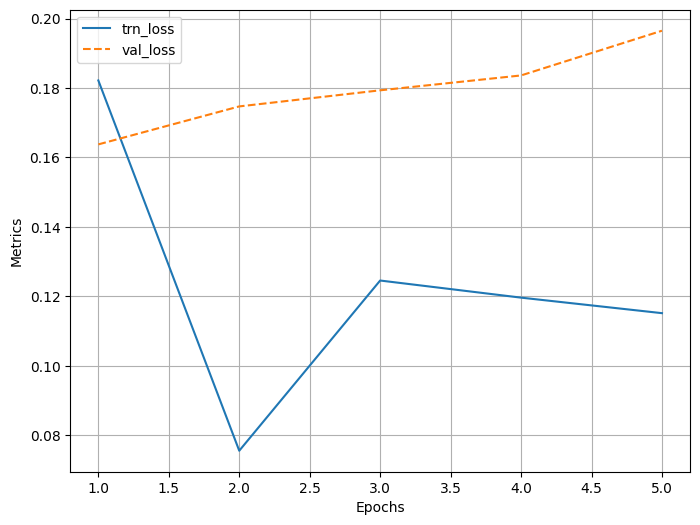

In [16]:
log.plot_epochs(['trn_loss','val_loss'])